In [39]:
import pandas as pd
import numpy as np

In [40]:
data = pd.read_csv("data.csv")

In [41]:
len(data)

2586531

In [81]:
data.head()

,Unnamed: 0,YEAR,LOAN_TYPE,PROP_TYPE,PURPOSE,OCCUPANCY,AMNT,PRE_APP,ACTION,MA,...,MINPOPCH,MED_INCCH,TCT2MSACH,OWNOCCCH,OWNOCC4CH,action,female,hispanic,black,co_black
0,0,2014,1,1,1,2,210,3,1,1,...,52.31,84900.0,58.72,149.0,327.0,1,0,0,0,0
1,3,2014,1,1,3,1,91,3,1,1,...,46.12,84900.0,86.38,2152.0,3002.0,1,0,0,0,0
2,4,2014,1,1,2,1,85,3,1,1,...,37.34,84900.0,111.17,1892.0,2177.0,1,0,0,0,0
3,5,2014,1,1,1,1,301,1,1,1,...,44.27,84900.0,87.68,1734.0,1829.0,1,1,0,0,0
4,7,2014,1,1,3,1,245,3,1,1,...,17.51,84900.0,129.43,3080.0,3541.0,1,0,0,0,0


In [103]:
df = data.sample(frac=0.01)

In [104]:
len(df)

25865

In [105]:
df.columns.unique()

Index([u'Unnamed: 0', u'YEAR', u'LOAN_TYPE', u'PROP_TYPE', u'PURPOSE',
       u'OCCUPANCY', u'AMNT', u'PRE_APP', u'ACTION', u'MA', u'STATE',
       u'COUNTY', u'TRACT', u'APP_ETH', u'COAPP_ETH', u'APP_RACE1',
       u'COAP_RACE1', u'APP_SEX', u'COAP_SEX', u'APP_INCCH', u'PURCHTYPE',
       u'HOEPA', u'POPCH', u'MINPOPCH', u'MED_INCCH', u'TCT2MSACH',
       u'OWNOCCCH', u'OWNOCC4CH', u'action', u'female', u'hispanic', u'black',
       u'co_black'],
      dtype='object')

In [106]:
df["american_indian"] = df["APP_RACE1"].apply(lambda x: 1 if x == 1 else 0)
indian = df["american_indian"].apply(lambda x: 1 if x == 1 else 0)

## Measure Social Bias

### target variavle: action

In [107]:
action = df.action
action.value_counts()

1    20519
0     5346
Name: action, dtype: int64

### protected class: female

In [108]:
female = df.female
female.value_counts()

0    18186
1     7679
Name: female, dtype: int64

In [109]:
from themis_ml.metrics import mean_difference, normalized_mean_difference, \
    mean_confidence_interval

In [110]:
def report_metric(metric, mean_diff, lower, upper):
    print("{metric}: {md:0.02f} - 95% CI [{lower:0.02f}, {upper:0.02f}]"
          .format(metric=metric, md=mean_diff, lower=lower, upper=upper))

report_metric(
    "mean difference",
    *map(lambda x: x * 100, mean_difference(action, female)))
report_metric(
    "normalized mean difference",
    *map(lambda x: x * 100, normalized_mean_difference(action, female)))

mean difference: 4.16 - 95% CI [3.09, 5.24]
normalized mean difference: 5.98 - 95% CI [4.90, 7.06]


### protected class: black 

In [111]:
# advantaged group: the others
# disadvantaged group: black 

In [112]:
black = df.black
black.value_counts()

0    23999
1     1866
Name: black, dtype: int64

In [113]:
report_metric(
    "mean difference",
    *map(lambda x: x * 100, mean_difference(action, black)))
report_metric(
    "normalized mean difference",
    *map(lambda x: x * 100, normalized_mean_difference(action, black)))

mean difference: 17.00 - 95% CI [15.10, 18.90]
normalized mean difference: 19.88 - 95% CI [17.99, 21.78]


### protected class: hispanic

In [114]:
# advantaged group: non-hispanic
# disadvantaged group: hispanic 

In [117]:
hispanic = df.hispanic
hispanic.value_counts()

0    22300
1     3565
Name: hispanic, dtype: int64

In [118]:
report_metric(
    "mean difference",
    *map(lambda x: x * 100, mean_difference(action, hispanic)))
report_metric(
    "normalized mean difference",
    *map(lambda x: x * 100, normalized_mean_difference(action, hispanic)))

mean difference: 3.88 - 95% CI [2.45, 5.31]
normalized mean difference: 4.21 - 95% CI [2.78, 5.64]


## protected class: american indian

In [119]:
# advantaged group: the others
# disadvantaged group: american indian 

In [120]:
american_indian = df['american_indian']
american_indian.value_counts()

0    25649
1      216
Name: american_indian, dtype: int64

In [121]:
report_metric(
    "mean difference",
    *map(lambda x: x * 100, mean_difference(action, american_indian)))
report_metric(
    "normalized mean difference",
    *map(lambda x: x * 100, normalized_mean_difference(action, american_indian)))

mean difference: 9.97 - 95% CI [4.55, 15.39]
normalized mean difference: 12.46 - 95% CI [7.04, 17.88]


## Establish Baseline Metrics

In [122]:
import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score)

In [123]:
features = [
        'YEAR','LOAN_TYPE','PROP_TYPE','PURPOSE','OCCUPANCY','AMNT','PRE_APP','MA','STATE',
        'COUNTY','TRACT','APP_ETH','COAPP_ETH','APP_RACE1','COAP_RACE1','APP_SEX','COAP_SEX',
        'APP_INCCH','PURCHTYPE','HOEPA','POPCH','MINPOPCH','MED_INCCH','TCT2MSACH','OWNOCCCH',
        'OWNOCC4CH'
]

In [124]:
N_SPLITS = 10
N_REPEATS = 5
RANDOM_STATE = 1000

def get_estimator_name(e):
    return "".join([x for x in str(type(e)).split(".")[-1]
                    if x.isalpha()])


def get_grid_params(grid_params_dict):
    """Get outer product of grid search parameters."""
    return [
        dict(params) for params in itertools.product(
            *[[(k, v_i) for v_i in v] for
              k, v in grid_params_dict.items()])]


def fit_with_s(estimator):
    has_relabeller = getattr(estimator, "relabeller", None) is not None
    child_estimator = getattr(estimator, "estimator", None)
    estimator_fit_with_s = getattr(estimator, "S_ON_FIT", False)
    child_estimator_fit_with_s = getattr(child_estimator, "S_ON_FIT", False)
    return has_relabeller or estimator_fit_with_s or\
        child_estimator_fit_with_s
    
    
def predict_with_s(estimator):
    estimator_pred_with_s = getattr(estimator, "S_ON_PREDICT", False)
    child_estimator = getattr(estimator, "estimator", None)
    return estimator_pred_with_s or \
        getattr(child_estimator, "S_ON_PREDICT", False)

def cross_validation_experiment(estimators, X, y, s, s_name, verbose=True):
    msg = "Training models: protected_class = %s" % s_name
    if verbose:
        print(msg)
        print("-" * len(msg))
    performance_scores = []
    # stratified groups tries to balance out y and s
    groups = [i + j for i, j in
              zip(y.astype(str), s.astype(str))]
    cv = RepeatedStratifiedKFold(
        n_splits=N_SPLITS,
        n_repeats=N_REPEATS,
        random_state=RANDOM_STATE)
    for e_name, e in estimators:
        if verbose:
            print("%s, fold:" % e_name),
        for i, (train, test) in enumerate(cv.split(X, y, groups=groups)):
            if verbose:
                print(i),
            # create train and validation fold partitions
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            s_train, s_test = s[train], s[test]

            # fit model and generate train and test predictions
            if fit_with_s(e):
                e.fit(X_train, y_train, s_train)
            else:
                e.fit(X_train, y_train)
                
            train_pred_args = (X_train, s_train) if predict_with_s(e) \
                else (X_train, )
            test_pred_args = (X_test, s_test) if predict_with_s(e) \
                else (X_test, )
                
            train_pred_prob = e.predict_proba(*train_pred_args)[:, 1]
            train_pred = e.predict(*train_pred_args)
            test_pred_prob = e.predict_proba(*test_pred_args)[:, 1]
            test_pred = e.predict(*test_pred_args)

            # train scores
            performance_scores.append([
                s_name, e_name, i, "train",
                # regular metrics
                roc_auc_score(y_train, train_pred_prob),

                # fairness metrics
                mean_difference(train_pred, s_train)[0],
                normalized_mean_difference(train_pred, s_train)[0]
            ])
            # test scores
            performance_scores.append([
                s_name, e_name, i, "test",
                # regular metrics
                roc_auc_score(y_test, test_pred_prob),
                # fairness metrics
                mean_difference(train_pred, s_train)[0],
                normalized_mean_difference(test_pred, s_test)[0]
            ])
        if verbose:
            print("")
    if verbose:
        print("")
    return pd.DataFrame(
        performance_scores,
        columns=[
            "protected_class", "estimator", "cv_fold", "fold_type",
            "auc", "mean_diff", "norm_mean_diff"])
            


In [125]:
# training and target data
X = df[features].values
y = df["action"].values
s_female = df["female"].values
s_black = df["black"].values
s_american_indian = df["american_indian"].values
s_hispanic = df["hispanic"].values


LOGISTIC_REGRESSION = LogisticRegression(
    penalty="l2", C=0.001, class_weight="balanced")
DECISION_TREE_CLF = DecisionTreeClassifier(
    criterion="entropy", max_depth=10, min_samples_leaf=10, max_features=10,
    class_weight="balanced")
RANDOM_FOREST_CLF = RandomForestClassifier(
    criterion="entropy", n_estimators=50, max_depth=10, max_features=10,
    min_samples_leaf=10, class_weight="balanced")
estimators = [
    ("LogisticRegression", LOGISTIC_REGRESSION),
    ("DecisionTree", DECISION_TREE_CLF),
    ("RandomForest", RANDOM_FOREST_CLF)
]
experiment_baseline_female = cross_validation_experiment(
    estimators, X, y, s_female, "female")
experiment_baseline_black = cross_validation_experiment(
    estimators, X, y, s_black, "black")
experiment_baseline_american_indian = cross_validation_experiment(
    estimators, X, y, s_american_indian, "american_indian")
experiment_baseline_hispanic = cross_validation_experiment(
    estimators, X, y, s_hispanic, "hispanic")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Training models: protected_class = black
----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
RandomForest, fo

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

UTILITY_METRICS = ["auc"]
FAIRNESS_METRICS = ["mean_diff"]

def summarize_experiment_results(experiment_df):
    return (
        experiment_df
        .drop("cv_fold", axis=1)
        .groupby(["protected_class", "estimator", "fold_type"])
        .mean())

experiment_baseline = pd.concat([
    experiment_baseline_female,
    experiment_baseline_black,
    experiment_baseline_american_indian,
    experiment_baseline_hispanic
])
experiment_baseline_summary = summarize_experiment_results(
    experiment_baseline)
experiment_baseline_summary.query("fold_type == 'test'")

auc  mean_diff  \
protected_class estimator          fold_type                        
american_indian DecisionTree       test       0.894434   0.094912   
                LogisticRegression test       0.902980   0.099237   
                RandomForest       test       0.914892   0.113979   
black           DecisionTree       test       0.894028   0.156533   
                LogisticRegression test       0.902931   0.162507   
                RandomForest       test       0.915165   0.171733   
female          DecisionTree       test       0.895168   0.046437   
                LogisticRegression test       0.902973   0.049036   
                RandomForest       test       0.915082   0.051051   
hispanic        DecisionTree       test       0.895801   0.009303   
                LogisticRegression test       0.902929   0.002552   
                RandomForest       test       0.915168   0.013858   

                                              norm_mean_diff  
protected_class estimator          fold_type                  
american_indian DecisionTree       test             0.118397  
                LogisticRegression test             0.166110  
                RandomForest       test             0.168575  
black           DecisionTree       test             0.225966  
                LogisticRegression test             0.261264  
                RandomForest       test             0.257836  
female          DecisionTree       test             0.051395  
                LogisticRegression test             0.059731  
                RandomForest       test             0.058372  
hispanic        DecisionTree       test             0.011770  
                LogisticRegression test             0.004008  
                RandomForest       test             0.015577

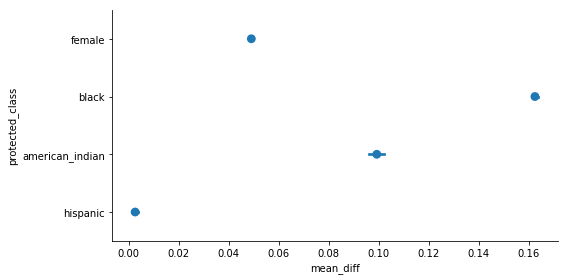

In [127]:
baseline_df = (
    experiment_baseline
    .query("fold_type == 'test' and estimator == 'LogisticRegression'")
)
sns.factorplot(y="protected_class", x="mean_diff", orient="h", data=baseline_df,
               size=4, aspect=2, join=False)

In [128]:
protected_classes = ["female", "black", "american_indian", "hispanic"]
for s in protected_classes:
    mean_ci = mean_confidence_interval(
        baseline_df.query("protected_class == @s").mean_diff.dropna())
    print(
        "grand_mean(norm_mean_diff) for %s - mean: %0.03f, 95%% CI(%0.03f, %0.03f)" %
        (s, mean_ci[0], mean_ci[1], mean_ci[2]))

grand_mean(norm_mean_diff) for female - mean: 0.049, 95% CI(0.048, 0.050)
grand_mean(norm_mean_diff) for black - mean: 0.163, 95% CI(0.161, 0.164)
grand_mean(norm_mean_diff) for american_indian - mean: 0.099, 95% CI(0.096, 0.102)
grand_mean(norm_mean_diff) for hispanic - mean: 0.003, 95% CI(0.002, 0.004)


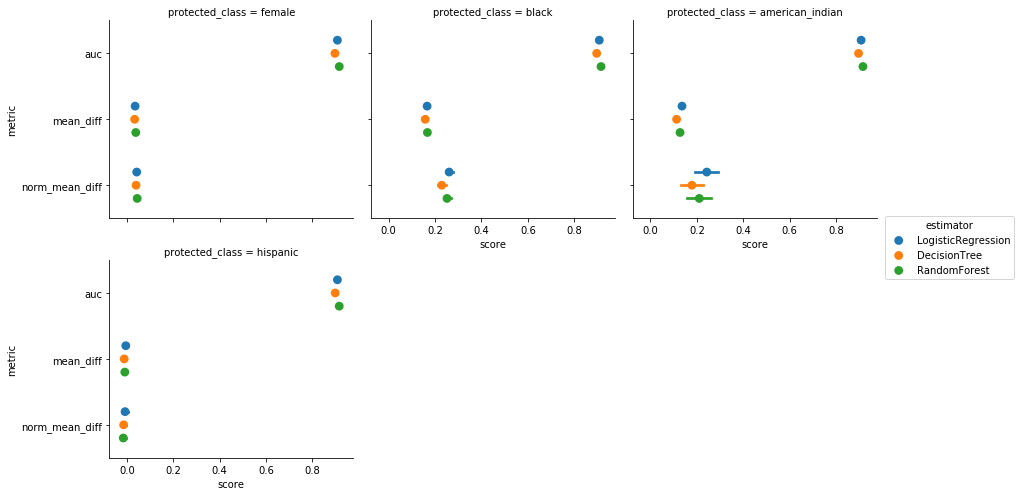

In [76]:
def plot_experiment_results(experiment_results):
    return (
          experiment_results
        .query("fold_type == 'test'")
        .drop(["fold_type", "cv_fold"], axis=1)
        .pipe(pd.melt, id_vars=["protected_class", "estimator"],
              var_name="metric", value_name="score")
        .pipe((sns.factorplot, "data"), y="metric",
              x="score", hue="estimator", col="protected_class", col_wrap=3,
              size=3.5, aspect=1.2, join=False, dodge=0.4))

plot_experiment_results(experiment_baseline);


In [129]:
from IPython.display import Markdown, display

def print_best_metrics(experiment_results, protected_classes):
    for pclass in protected_classes:
        msg = "#### protected class = %s:" % pclass
        display(Markdown(msg))
        exp_df = experiment_results[
            (experiment_results["protected_class"] == pclass) &
            (experiment_results["fold_type"] == "test")]
        msg = ""
        
        for m in UTILITY_METRICS:
            utility_msg = \
                "- best utility measured by %s (higher is better)" % m
            best_model = (
                exp_df
                .sort_values(m, ascending=False)
                .drop(["fold_type"], axis=1)
                .iloc[0][[m, "estimator"]])
            msg += utility_msg + " = %0.03f: %s\n" % \
                   (best_model[0], best_model[1])
        
        for m in FAIRNESS_METRICS:
            fairness_msg = \
                "- best fairness measured by %s (lower is better)" % m
            best_model = (
                exp_df
                # score closer to zero is better
                .assign(abs_measure=lambda df: df[m].abs())
                .sort_values("abs_measure")
                .drop(["abs_measure", "fold_type"], axis=1)
                .iloc[0][[m, "estimator"]])
            msg += fairness_msg + " = %0.03f: %s\n" % \
                   (best_model[0], best_model[1])
        display(Markdown(msg))
        
print_best_metrics(
    experiment_baseline_summary.reset_index(),
    ["female", "black", "american_indian", "hispanic"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.915: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.046: DecisionTree


#### protected class = black:

- best utility measured by auc (higher is better) = 0.915: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.157: DecisionTree


#### protected class = american_indian:

- best utility measured by auc (higher is better) = 0.915: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.095: DecisionTree


#### protected class = hispanic:

- best utility measured by auc (higher is better) = 0.915: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.003: LogisticRegression


## Naive Fairness-aware Approach: Remove Protected Class


In [130]:
# create feature sets that remove variables with protected class information
feature_set_no_sex = [f for f in features if f != "APP_SEX"]
feature_set_no_race = [f for f in features if f != "APP_RACE1"]
feature_set_no_hispanic = [f for f in features if f != "APP_ETH"]

In [131]:
X_no_sex = df[feature_set_no_sex].values
X_no_race = df[feature_set_no_race].values
X_no_hispanic = df[feature_set_no_hispanic].values 

In [132]:
experiment_naive_female = cross_validation_experiment(
    estimators, X_no_sex, y, s_female, "female")
experiment_naive_black = cross_validation_experiment(
    estimators, X_no_race, y, s_black, "black")
experiment_naive_american_indian = cross_validation_experiment(
    estimators, X_no_race, y, s_american_indian, "american_indian")
experiment_naive_hispanic = cross_validation_experiment(
    estimators, X_no_hispanic, y, s_hispanic, "hispanic")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Training models: protected_class = black
----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
RandomForest, fo

In [134]:
experiment_naive = pd.concat([
    experiment_naive_female,
    experiment_naive_black,
    experiment_naive_american_indian,
    experiment_naive_hispanic
])
experiment_naive_summary = summarize_experiment_results(experiment_naive)
experiment_naive_summary.query("fold_type == 'test'")

auc  mean_diff  \
protected_class estimator          fold_type                        
american_indian DecisionTree       test       0.894608   0.094453   
                LogisticRegression test       0.902760   0.085162   
                RandomForest       test       0.914785   0.112934   
black           DecisionTree       test       0.896003   0.155597   
                LogisticRegression test       0.902730   0.158377   
                RandomForest       test       0.914875   0.170924   
female          DecisionTree       test       0.894484   0.046337   
                LogisticRegression test       0.902819   0.045624   
                RandomForest       test       0.915076   0.052570   
hispanic        DecisionTree       test       0.894364   0.008263   
                LogisticRegression test       0.902675  -0.002138   
                RandomForest       test       0.914662   0.014001   

                                              norm_mean_diff  
protected_class estimator          fold_type                  
american_indian DecisionTree       test             0.150239  
                LogisticRegression test             0.144310  
                RandomForest       test             0.162436  
black           DecisionTree       test             0.232152  
                LogisticRegression test             0.253465  
                RandomForest       test             0.257585  
female          DecisionTree       test             0.055205  
                LogisticRegression test             0.055770  
                RandomForest       test             0.061361  
hispanic        DecisionTree       test             0.010927  
                LogisticRegression test            -0.002006  
                RandomForest       test             0.016556

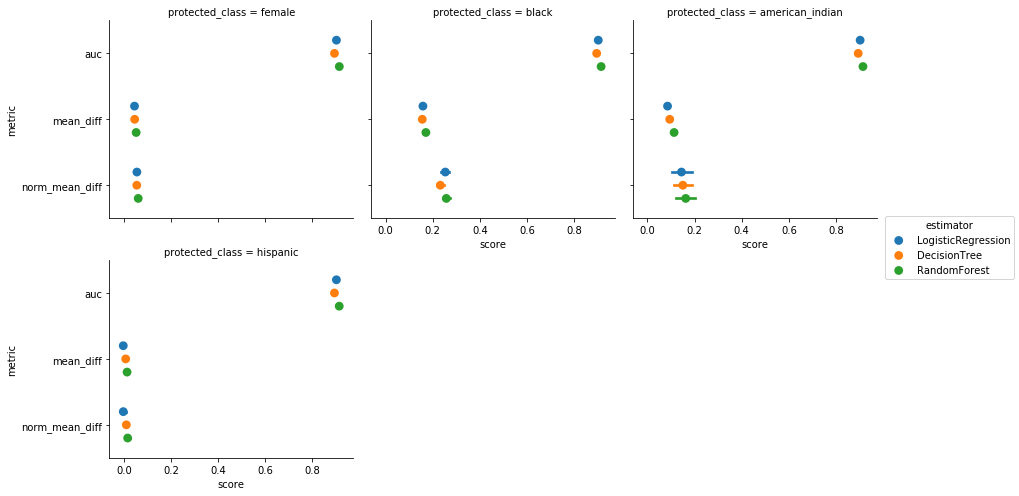

In [135]:
plot_experiment_results(experiment_naive)

In [136]:
print_best_metrics(
    experiment_naive_summary.reset_index(),
    ["female", "black", "american_indian","hispanic"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.915: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.046: LogisticRegression


#### protected class = black:

- best utility measured by auc (higher is better) = 0.915: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.156: DecisionTree


#### protected class = american_indian:

- best utility measured by auc (higher is better) = 0.915: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.085: LogisticRegression


#### protected class = hispanic:

- best utility measured by auc (higher is better) = 0.915: RandomForest
- best fairness measured by mean_diff (lower is better) = -0.002: LogisticRegression


## Fairness-aware Method: Relabelling

In [137]:
from sklearn.base import clone

from themis_ml.preprocessing.relabelling import Relabeller
from themis_ml.meta_estimators import FairnessAwareMetaEstimator

# here we use the relabeller class to create new y vectors for each of the
# protected class contexts.

# we also use the FairnessAwareMetaEstimator as a convenience class to
# compose together different fairness-aware methods. This wraps around the
# estimators that we defined in the previous
relabeller = Relabeller()
relabelling_estimators = [
    (name, FairnessAwareMetaEstimator(e, relabeller=relabeller))
    for name, e in estimators]

experiment_relabel_female = cross_validation_experiment(
    relabelling_estimators, X_no_sex, y, s_female, "female")
experiment_relabel_black = cross_validation_experiment(
    relabelling_estimators, X_no_race, y, s_black, "black")
experiment_relabel_american_indian = cross_validation_experiment(
    relabelling_estimators, X_no_race, y, s_american_indian, "american_indian")
experiment_relabel_hispanic = cross_validation_experiment(
    relabelling_estimators, X_no_hispanic, y, s_hispanic, "hispanic")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Training models: protected_class = black
----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
RandomForest, fo

In [138]:
experiment_relabel = pd.concat([
    experiment_relabel_female,
    experiment_relabel_black,
    experiment_relabel_american_indian,
    experiment_relabel_hispanic
])
experiment_relabel_summary = summarize_experiment_results(experiment_relabel)
experiment_relabel_summary.query("fold_type == 'test'")

auc  mean_diff  \
protected_class estimator          fold_type                        
american_indian DecisionTree       test       0.895743   0.086054   
                LogisticRegression test       0.902414   0.085988   
                RandomForest       test       0.914615   0.103589   
black           DecisionTree       test       0.892237   0.131770   
                LogisticRegression test       0.899192   0.165556   
                RandomForest       test       0.911424   0.157188   
female          DecisionTree       test       0.892153   0.025759   
                LogisticRegression test       0.898441   0.056689   
                RandomForest       test       0.912349   0.031208   
hispanic        DecisionTree       test       0.894790  -0.001210   
                LogisticRegression test       0.900495   0.007523   
                RandomForest       test       0.914147   0.006274   

                                              norm_mean_diff  
protected_class estimator          fold_type                  
american_indian DecisionTree       test             0.140425  
                LogisticRegression test             0.144821  
                RandomForest       test             0.169908  
black           DecisionTree       test             0.214121  
                LogisticRegression test             0.259840  
                RandomForest       test             0.249575  
female          DecisionTree       test             0.035561  
                LogisticRegression test             0.068221  
                RandomForest       test             0.042530  
hispanic        DecisionTree       test             0.004306  
                LogisticRegression test             0.011767  
                RandomForest       test             0.012421

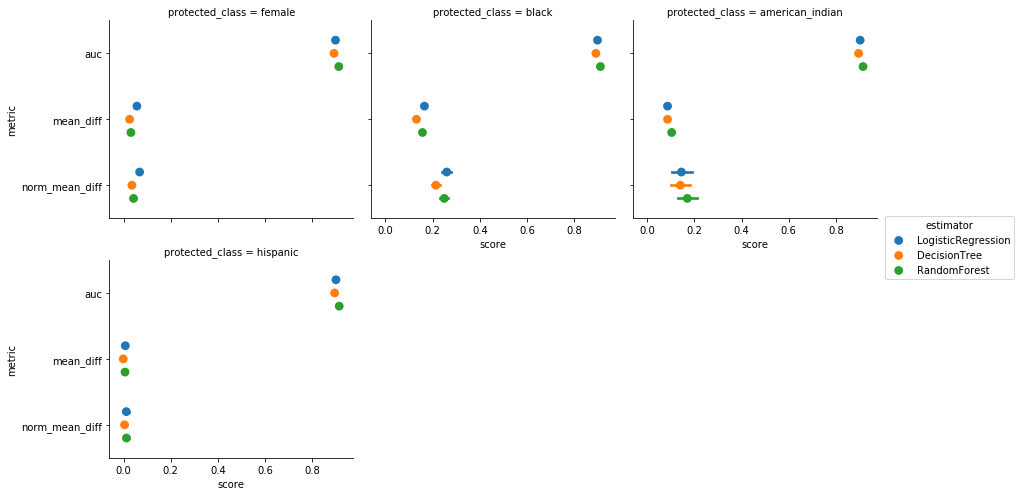

In [139]:
plot_experiment_results(experiment_relabel)

In [140]:
print_best_metrics(
    experiment_relabel_summary.reset_index(),
    ["female", "black", "american_indian","hispanic"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.912: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.026: DecisionTree


#### protected class = black:

- best utility measured by auc (higher is better) = 0.911: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.132: DecisionTree


#### protected class = american_indian:

- best utility measured by auc (higher is better) = 0.915: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.086: LogisticRegression


#### protected class = hispanic:

- best utility measured by auc (higher is better) = 0.914: RandomForest
- best fairness measured by mean_diff (lower is better) = -0.001: DecisionTree


## Validation Curve: Logistic Regression

In [1]:
LOGREG_L2_PARAM = [
    3, 1, 3e-1, 1e-1, 3e-2, 1e-2, 3e-3, 1e-3,
    3e-4, 1e-4, 3e-5, 1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8]

def validation_curve_experiment(
        estimator_name, estimator, param_name, param_list, update_func):
    validaton_curve_experiment = []
    for param in param_list:
        e = clone(estimator)
        e = update_func(e, param_name, param)
        estimators = [(estimator_name, e)]
        experiment_relabel_female = cross_validation_experiment(
            estimators, X_no_sex, y, s_female, "female",
            verbose=False)
        experiment_relabel_black = cross_validation_experiment(
            estimators, X_no_race, y, s_black, "black",
            verbose=False)
        experiment_relabel_american_indian = cross_validation_experiment(
            estimators, X_no_race, y, s_american_indian, "american_indian",
            verbose=False)
        experiment_relabel_hispanic = cross_validation_experiment(
            estimators, X_no_hispanic, y, s_hispanic, "hispanic",
            verbose=False)
        validaton_curve_experiment.extend(
            [experiment_relabel_female.assign(**{param_name: param}),
             experiment_relabel_black.assign(**{param_name: param}),
             experiment_relabel_american_indian.assign(**{param_name: param}),
             experiment_relabel_hispanic.assign(**{param_name: param})])
    return pd.concat(validaton_curve_experiment)


def update_relabeller(e, param_name, param):
    e = clone(e)
    child_estimator = clone(e.estimator)
    child_estimator.set_params(**{param_name: param})
    e.set_params(estimator=child_estimator)
    return e
        

relabel_validaton_curve_experiment = validation_curve_experiment(
    "LogisticRegression", FairnessAwareMetaEstimator(
        LOGISTIC_REGRESSION, relabeller=Relabeller()),
    "C", LOGREG_L2_PARAM, update_relabeller)

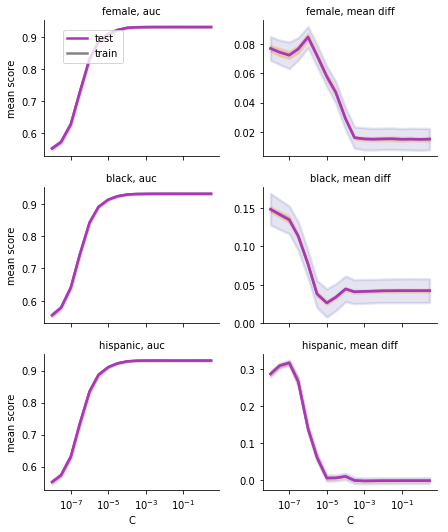

In [45]:
def validation_curve_plot(x, y, **kwargs):
    ax = plt.gca()
    lw = 2.5
    data = kwargs.pop("data")
    train_data = data.query("fold_type == 'train'")
    test_data = data.query("fold_type == 'test'")
    grp_data_train = train_data.groupby(x)
    grp_data_test = test_data.groupby(x)
    mean_data_train = grp_data_train[y].mean()
    mean_data_test = grp_data_test[y].mean()
    std_data_train = grp_data_train[y].std()
    std_data_test = grp_data_test[y].std()
    ax.semilogx(mean_data_train.index, mean_data_train,
                label="train", color="#848484", lw=lw)
    ax.semilogx(mean_data_test.index, mean_data_test,
                label="test", color="#ae33bf", lw=lw)
    # # Add error region
    ax.fill_between(mean_data_train.index, mean_data_train - std_data_train,
                    mean_data_train + std_data_train, alpha=0.2,
                    color="darkorange", lw=lw)
    ax.fill_between(mean_data_test.index, mean_data_test - std_data_test,
                    mean_data_test + std_data_test, alpha=0.1,
                    color="navy", lw=lw)

relabel_validaton_curve_experiment_df = (
    relabel_validaton_curve_experiment
    .pipe(pd.melt,
          id_vars=["protected_class", "estimator", "cv_fold", "fold_type",
                   "C"],
          value_vars=["auc", "mean_diff"],
          var_name="metric", value_name="score")
    .assign(
        protected_class=lambda df: df.protected_class.str.replace("_", " "),
        metric=lambda df: df.metric.str.replace("_", " "))
    .rename(columns={"score": "mean score"})
)

# relabel_validaton_curve_experiment_df
g = sns.FacetGrid(
    relabel_validaton_curve_experiment_df,
    row="protected_class",
    col="metric", size=2.5, aspect=1.1, sharey=False,
    margin_titles=False)
g = g.map_dataframe(validation_curve_plot, "C", "mean score")
g.set_titles(template="{row_name}, {col_name}")
# g.add_legend()
# g.add_legend(bbox_to_anchor=(0.275, 0.91))
g.add_legend(bbox_to_anchor=(0.28, 0.9))
g.fig.tight_layout()
g.savefig("logistic_regression_validation_curve1.png");


## Fairness-aware Method: Reject-option Classification¶

In [142]:
from themis_ml.postprocessing.reject_option_classification import \
    SingleROClassifier

# use the estimators defined above to define the linear additive
# counterfactually fair models
single_roc_clf_estimators = [
    (name, SingleROClassifier(estimator=e))
    for name, e in estimators]

experiment_single_roc_female = cross_validation_experiment(
    single_roc_clf_estimators, X_no_sex, y, s_female, "female")
experiment_single_roc_black = cross_validation_experiment(
    single_roc_clf_estimators, X_no_race, y, s_black, "black")
experiment_single_roc_american_indian = cross_validation_experiment(
    single_roc_clf_estimators, X_no_race, y, s_american_indian, "american_indian")
experiment_single_roc_hispanic = cross_validation_experiment(
    single_roc_clf_estimators, X_no_hispanic, y, s_hispanic, "hispanic")

 Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Training models: protected_class = black
----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
RandomForest, f

In [143]:
experiment_single_roc = pd.concat([
    experiment_single_roc_female,
    experiment_single_roc_black,
    experiment_single_roc_american_indian,
    experiment_single_roc_hispanic
])
experiment_single_roc_summary = summarize_experiment_results(
    experiment_single_roc)
experiment_single_roc_summary.query("fold_type == 'test'")

auc  mean_diff  \
protected_class estimator          fold_type                        
american_indian DecisionTree       test       0.894127   0.098983   
                LogisticRegression test       0.898464   0.107929   
                RandomForest       test       0.914000   0.116116   
black           DecisionTree       test       0.892937   0.164684   
                LogisticRegression test       0.898471   0.172687   
                RandomForest       test       0.913843   0.173542   
female          DecisionTree       test       0.895650   0.050123   
                LogisticRegression test       0.898413   0.067073   
                RandomForest       test       0.914496   0.058796   
hispanic        DecisionTree       test       0.895159   0.012634   
                LogisticRegression test       0.898382   0.024823   
                RandomForest       test       0.914349   0.020848   

                                              norm_mean_diff  
protected_class estimator          fold_type                  
american_indian DecisionTree       test             0.139125  
                LogisticRegression test             0.179902  
                RandomForest       test             0.180409  
black           DecisionTree       test             0.234064  
                LogisticRegression test             0.275421  
                RandomForest       test             0.255230  
female          DecisionTree       test             0.056080  
                LogisticRegression test             0.081419  
                RandomForest       test             0.064775  
hispanic        DecisionTree       test             0.015014  
                LogisticRegression test             0.037443  
                RandomForest       test             0.029931

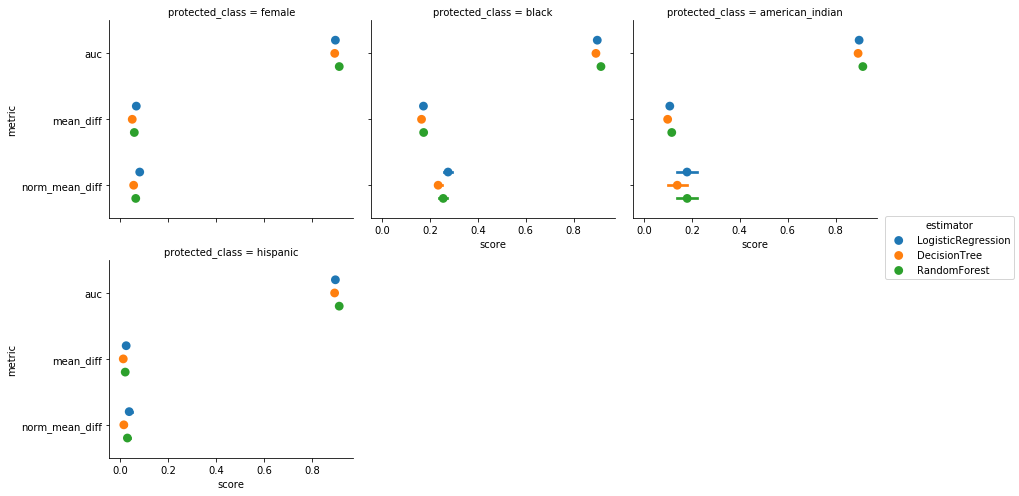

In [144]:
plot_experiment_results(experiment_single_roc)

In [146]:
print_best_metrics(
    experiment_single_roc.reset_index(),
    ["female", "black", "american_indian","hispanic"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.925: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.034: DecisionTree


#### protected class = black:

- best utility measured by auc (higher is better) = 0.925: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.141: DecisionTree


#### protected class = american_indian:

- best utility measured by auc (higher is better) = 0.925: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.046: DecisionTree


#### protected class = hispanic:

- best utility measured by auc (higher is better) = 0.925: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.000: DecisionTree


## Comparison of Fairness-aware Techniques

In [156]:
compare_experiments = (
    pd.concat([
        experiment_baseline.assign(experiment="B"),
        experiment_naive.assign(experiment="RPA"),
        experiment_relabel.assign(experiment="RTV"),
        #experiment_acf.assign(experiment="CFM"),
        experiment_single_roc.assign(experiment="ROC")
    ])
    .assign(
        protected_class=lambda df: df.protected_class.str.replace("_", " "),
    )
)
compare_experiments

,protected_class,estimator,cv_fold,fold_type,auc,mean_diff,norm_mean_diff,experiment
0,female,LogisticRegression,0,train,0.903836,0.048911,0.059350,B
1,female,LogisticRegression,0,test,0.903831,0.048911,0.046757,B
2,female,LogisticRegression,1,train,0.903552,0.045271,0.054784,B
3,female,LogisticRegression,1,test,0.904086,0.045271,0.086809,B
4,female,LogisticRegression,2,train,0.905130,0.048185,0.058266,B
5,female,LogisticRegression,2,test,0.890197,0.048185,0.092621,B
6,female,LogisticRegression,3,train,0.904031,0.048034,0.058285,B
7,female,LogisticRegression,3,test,0.903995,0.048034,0.045916,B
8,female,LogisticRegression,4,train,0.904464,0.047039,0.057025,B
9,female,LogisticRegression,4,test,0.899056,0.047039,0.086557,B


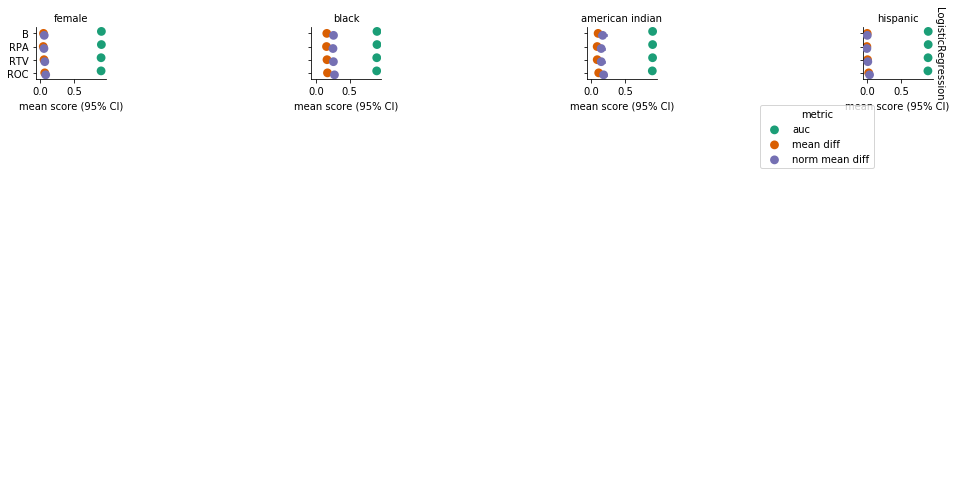

In [148]:
comparison_palette = sns.color_palette("Dark2", n_colors=8)

def compare_experiment_results_multiple_model(experiment_results):
    g = (
        experiment_results
        .query("fold_type == 'test'")
        .drop(["cv_fold"], axis=1)
        .pipe(pd.melt, id_vars=["experiment", "protected_class", "estimator",
                                "fold_type"],
              var_name="metric", value_name="score")
        .assign(
            metric=lambda df: df.metric.str.replace("_", " "))
        .pipe((sns.factorplot, "data"), y="experiment",
              x="score", hue="metric",
              col="protected_class", row="estimator",
              join=False, size=3, aspect=1.1, dodge=0.3,
              palette=comparison_palette, margin_titles=True, legend=False))
    g.set_axis_labels("mean score (95% CI)")
    for ax in g.axes.ravel():
        ax.set_ylabel("")
        plt.setp(ax.texts, text="")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    plt.legend(title="metric", loc=9, bbox_to_anchor=(-0.65, -0.4))
    g.fig.legend(loc=9, bbox_to_anchor=(0.5, -0.3))
    g.fig.tight_layout()
    g.savefig("fairness_aware_comparison.png", dpi=500);

compare_experiment_results_multiple_model(
    compare_experiments.query("estimator == 'LogisticRegression'"));

In [150]:
from scipy import stats

def compute_corr_pearson(x, y, ci=0.95):
    corr = stats.pearsonr(x, y)
    z = np.arctanh(corr[0])
    sigma = (1 / ((len(x) - 3) ** 0.5))
    cint = z + np.array([-1, 1]) * sigma * stats.norm.ppf((1 + ci ) / 2)
    return corr, np.tanh(cint)

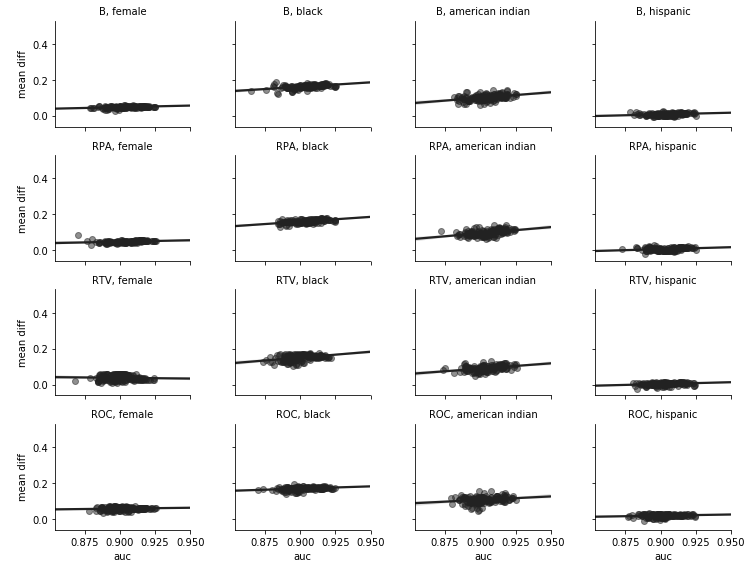

In [151]:
black_palette = sns.color_palette(["#222222"])

def plot_utility_fairness_tradeoff(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    sns_ax = sns.regplot(x=x, y=y, data=data, scatter_kws={'alpha':0.5},
                         **kwargs)
    (corr, p_val), ci = compute_corr_pearson(data[x], data[y])
    r_text = 'r = %0.02f (%0.02f, %0.02f)' % \
        (corr, ci[0], ci[1])
    sns_ax.annotate(
        r_text, xy=(0.7, 0),
        xytext=(0.07, 0.91),
        textcoords='axes fraction',
        fontweight="bold",
        fontsize=9,
        color="gray"
    )
    bottom_padding = 0.05
    top_padding = 0.5
    ylim = (data[y].min() - bottom_padding, data[y].max() + top_padding)
    sns_ax.set_ylim(*ylim)


g = sns.FacetGrid(
    (
        compare_experiments
        .drop("cv_fold", axis=1)
        .reset_index()
        .query("fold_type == 'test'")
        .rename(
            columns={"mean_diff": "mean diff"})
    ),
    col="protected_class",
    row="experiment",
    hue="experiment",
    size=2.0, aspect=1.3, sharey=True,
    palette=black_palette)
g.map_dataframe(plot_utility_fairness_tradeoff, "auc", "mean diff")
g.set_titles(template="{row_name}, {col_name}")
g.fig.tight_layout()
g.savefig("fairness_utility_tradeoff.png", dpi=500);

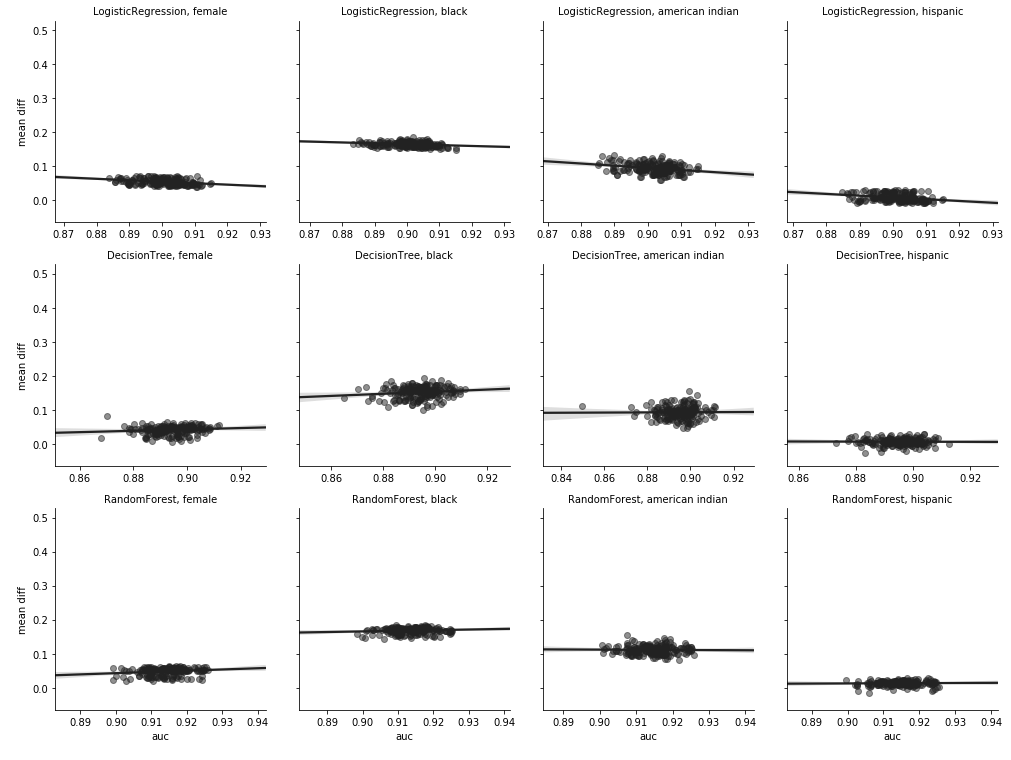

In [152]:
g = sns.FacetGrid(
    (
        compare_experiments
        .drop("cv_fold", axis=1)
        .reset_index()
        .query("fold_type == 'test'")
        .rename(
            columns={"mean_diff": "mean diff"})
    ),
    col="protected_class",
    row="estimator",
    hue="estimator",
    size=3.5, aspect=1,
    sharey=True, sharex=False,
    palette=black_palette)
g.map_dataframe(plot_utility_fairness_tradeoff, "auc", "mean diff")
g.set_titles(template="{row_name}, {col_name}")
g.fig.tight_layout()